In [1]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from matplotlib import pyplot as plt
from slackclient import SlackClient
from keras.models import load_model
from keras.optimizers import Adam
from space_utils import *
from matplotlib import pyplot as plt

from keras import regularizers
from time import process_time
from shutil import copyfile

import pandas as pd
import numpy as np

import pickle
import random
import os
import wget

pd.options.display.max_columns = 45

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12153718584827694112
]


## Introduction
---
Hi and hello! Welcome to the step-by-step guide of how to train a model to detect supernova.

Throughout this guide you will learn about the data that we used, the building of a model in Keras, and how we went about record keeping for our experiments.

There is a seperate file called utils.py that holds any functions that we wrote for our project.

## Constants
---
We find it best to define a set of constants at the beginning of the notebook for clarity.

In [3]:
HOME_PATH = ""
DATA_PATH = "data/"
MODEL_PATH = "model/"
RESULTS_PATH = "results/"

ALL_DATA_FILE = "extra_small_all_object_data_in_dictionary_format.pkl"
NORMALIZED_IMAGE_DATA_FILE = "extra_small_normalized_image_object_data_in_numpy_format.pkl"

MODEL_LOGGING_FILE = "model_results.csv"

In [4]:
if os.path.isdir(DATA_PATH) == False:
   os.mkdir(DATA_PATH)

if os.path.isdir(MODEL_PATH) == False:
   os.mkdir(MODEL_PATH)

if os.path.isdir(RESULTS_PATH) == False:
   os.mkdir(RESULTS_PATH)

In [5]:
ALL_DATA_FILE_URL = 'https://s3.amazonaws.com/space2vec-public/post3/extra_small_all_object_data_in_dictionary_format.pkl'
NORMALIZED_IMAGE_DATA_FILE_URL = 'https://s3.amazonaws.com/space2vec-public/post3/extra_small_normalized_image_object_data_in_numpy_format.pkl'

if os.path.isfile(DATA_PATH + ALL_DATA_FILE) == False:
    wget.download(ALL_DATA_FILE_URL)
    os.rename(ALL_DATA_FILE, DATA_PATH + ALL_DATA_FILE)

if os.path.isfile(DATA_PATH + NORMALIZED_IMAGE_DATA_FILE) == False:
    wget.download(NORMALIZED_IMAGE_DATA_FILE_URL)
    os.rename(NORMALIZED_IMAGE_DATA_FILE_URL, DATA_PATH + NORMALIZED_IMAGE_DATA_FILE)

## Data Loading
---
We first have to load in the data to be used for model training.

This consists of 2 main data files stored in the variables ALL_DATA_FILE and NORMALIZED_IMAGE_DATA_FILE.

<strong>ALL_DATA_FILE</strong>: We have any information that will be relevent to an object observation in here. This is a dictionary
with 4 keys -- images, targets, file_paths, observation_numbers -- where each key holds a Numpy array. The indices of
each array are all properly aligned according to their respective objects (explained in the table).

| X_normalized        | X        | Y        | file_path        | observation_number        |
|---------------------|----------|----------|------------------|---------------------------|
| obj_0_X_normalized  | obj_0_X  | obj_0_Y  | obj_0_file_path  | obj_0_observation_number  |
| obj_42_X_normalized | obj_42_X | obj_42_Y | obj_42_file_path | obj_42_observation_number |

<strong>NORMALIZED_IMAGE_DATA_FILE</strong>: This is simply a Numpy array of photos ready to be fed into a model. They are normalized and the channels -- search image, template image, difference image -- are organized properly. The preparation of this data is in >>>FILL IN<<<.

In [6]:
all_data = pickle.load(open(DATA_PATH + ALL_DATA_FILE, "rb"))
all_images_normalized = pickle.load(open(DATA_PATH + NORMALIZED_IMAGE_DATA_FILE, "rb"))

In [7]:
notSupernovaImages = all_data['images'][all_data['targets'] == 0][0:5]
supernovaImages = all_data['images'][all_data['targets'] == 1][0:5]

### Images (not supernova)

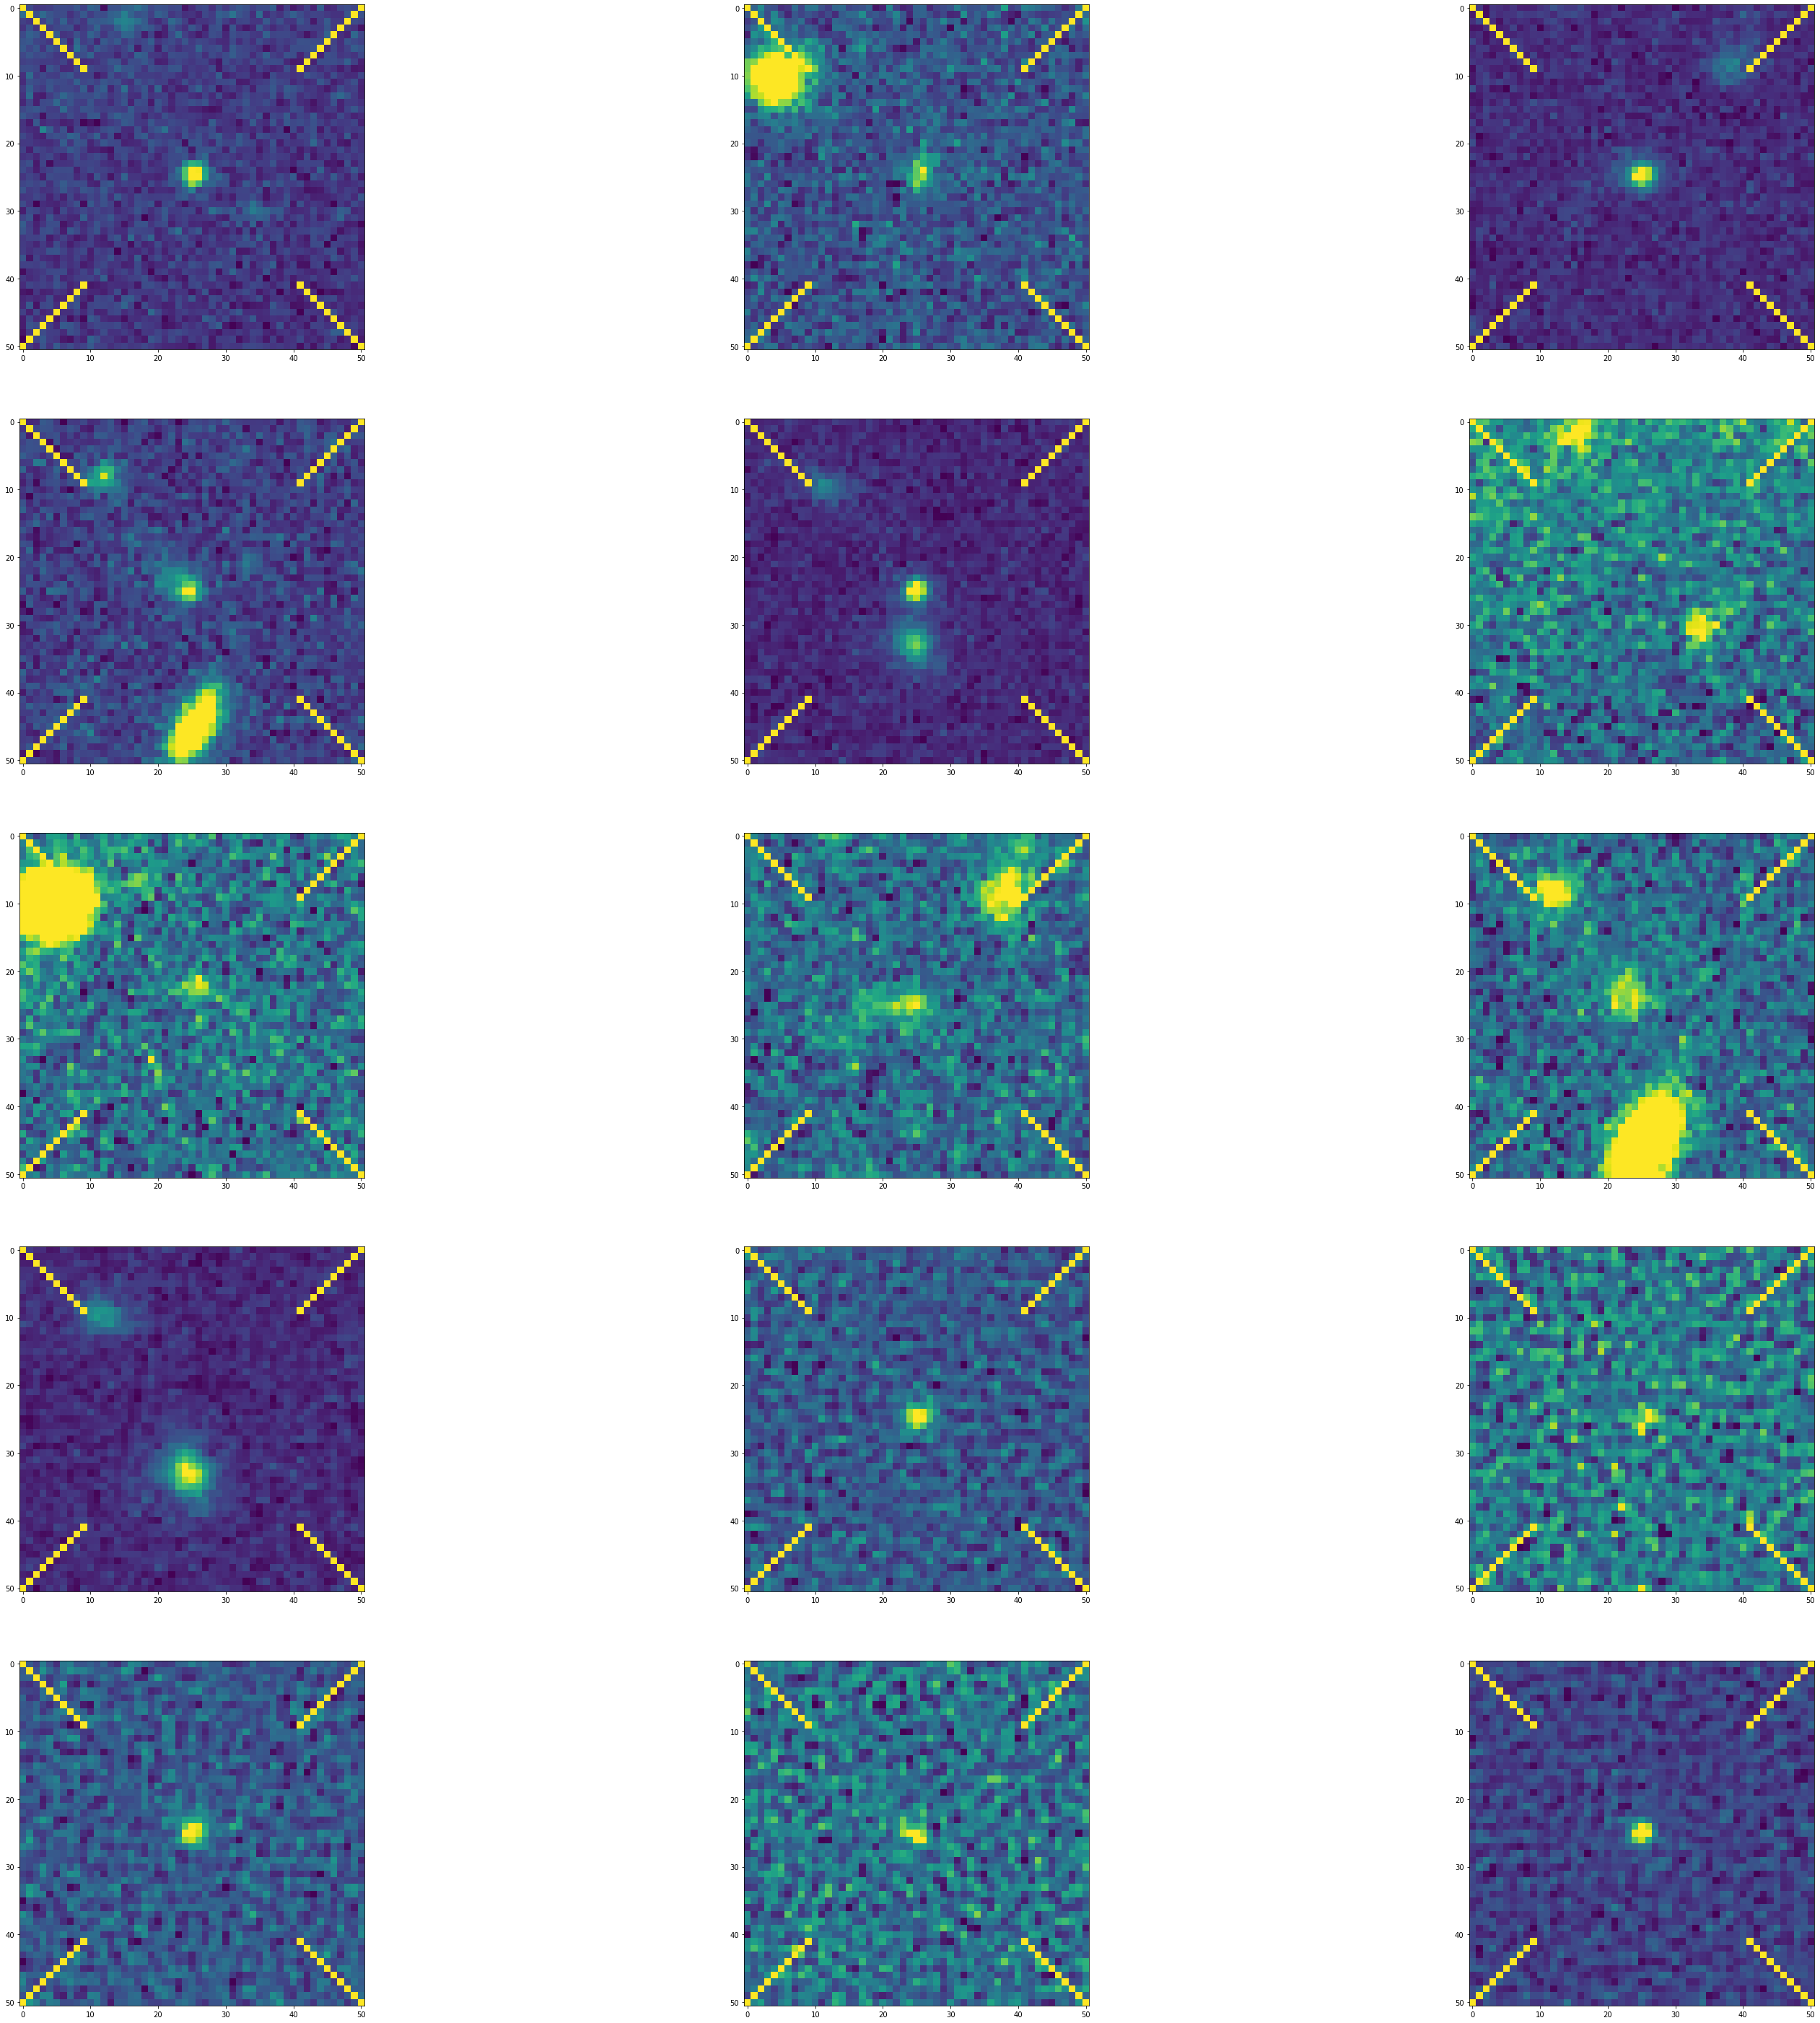

In [8]:
fig = plt.figure(figsize=(51, 51))
columns = 3
rows = 5

i = 1
for c in range(0, columns):
    for r in range(0, rows):
        fig.add_subplot(rows, columns, i)
        plt.imshow(notSupernovaImages[r][c])
        i += 1
plt.show()

### Images (supernova)

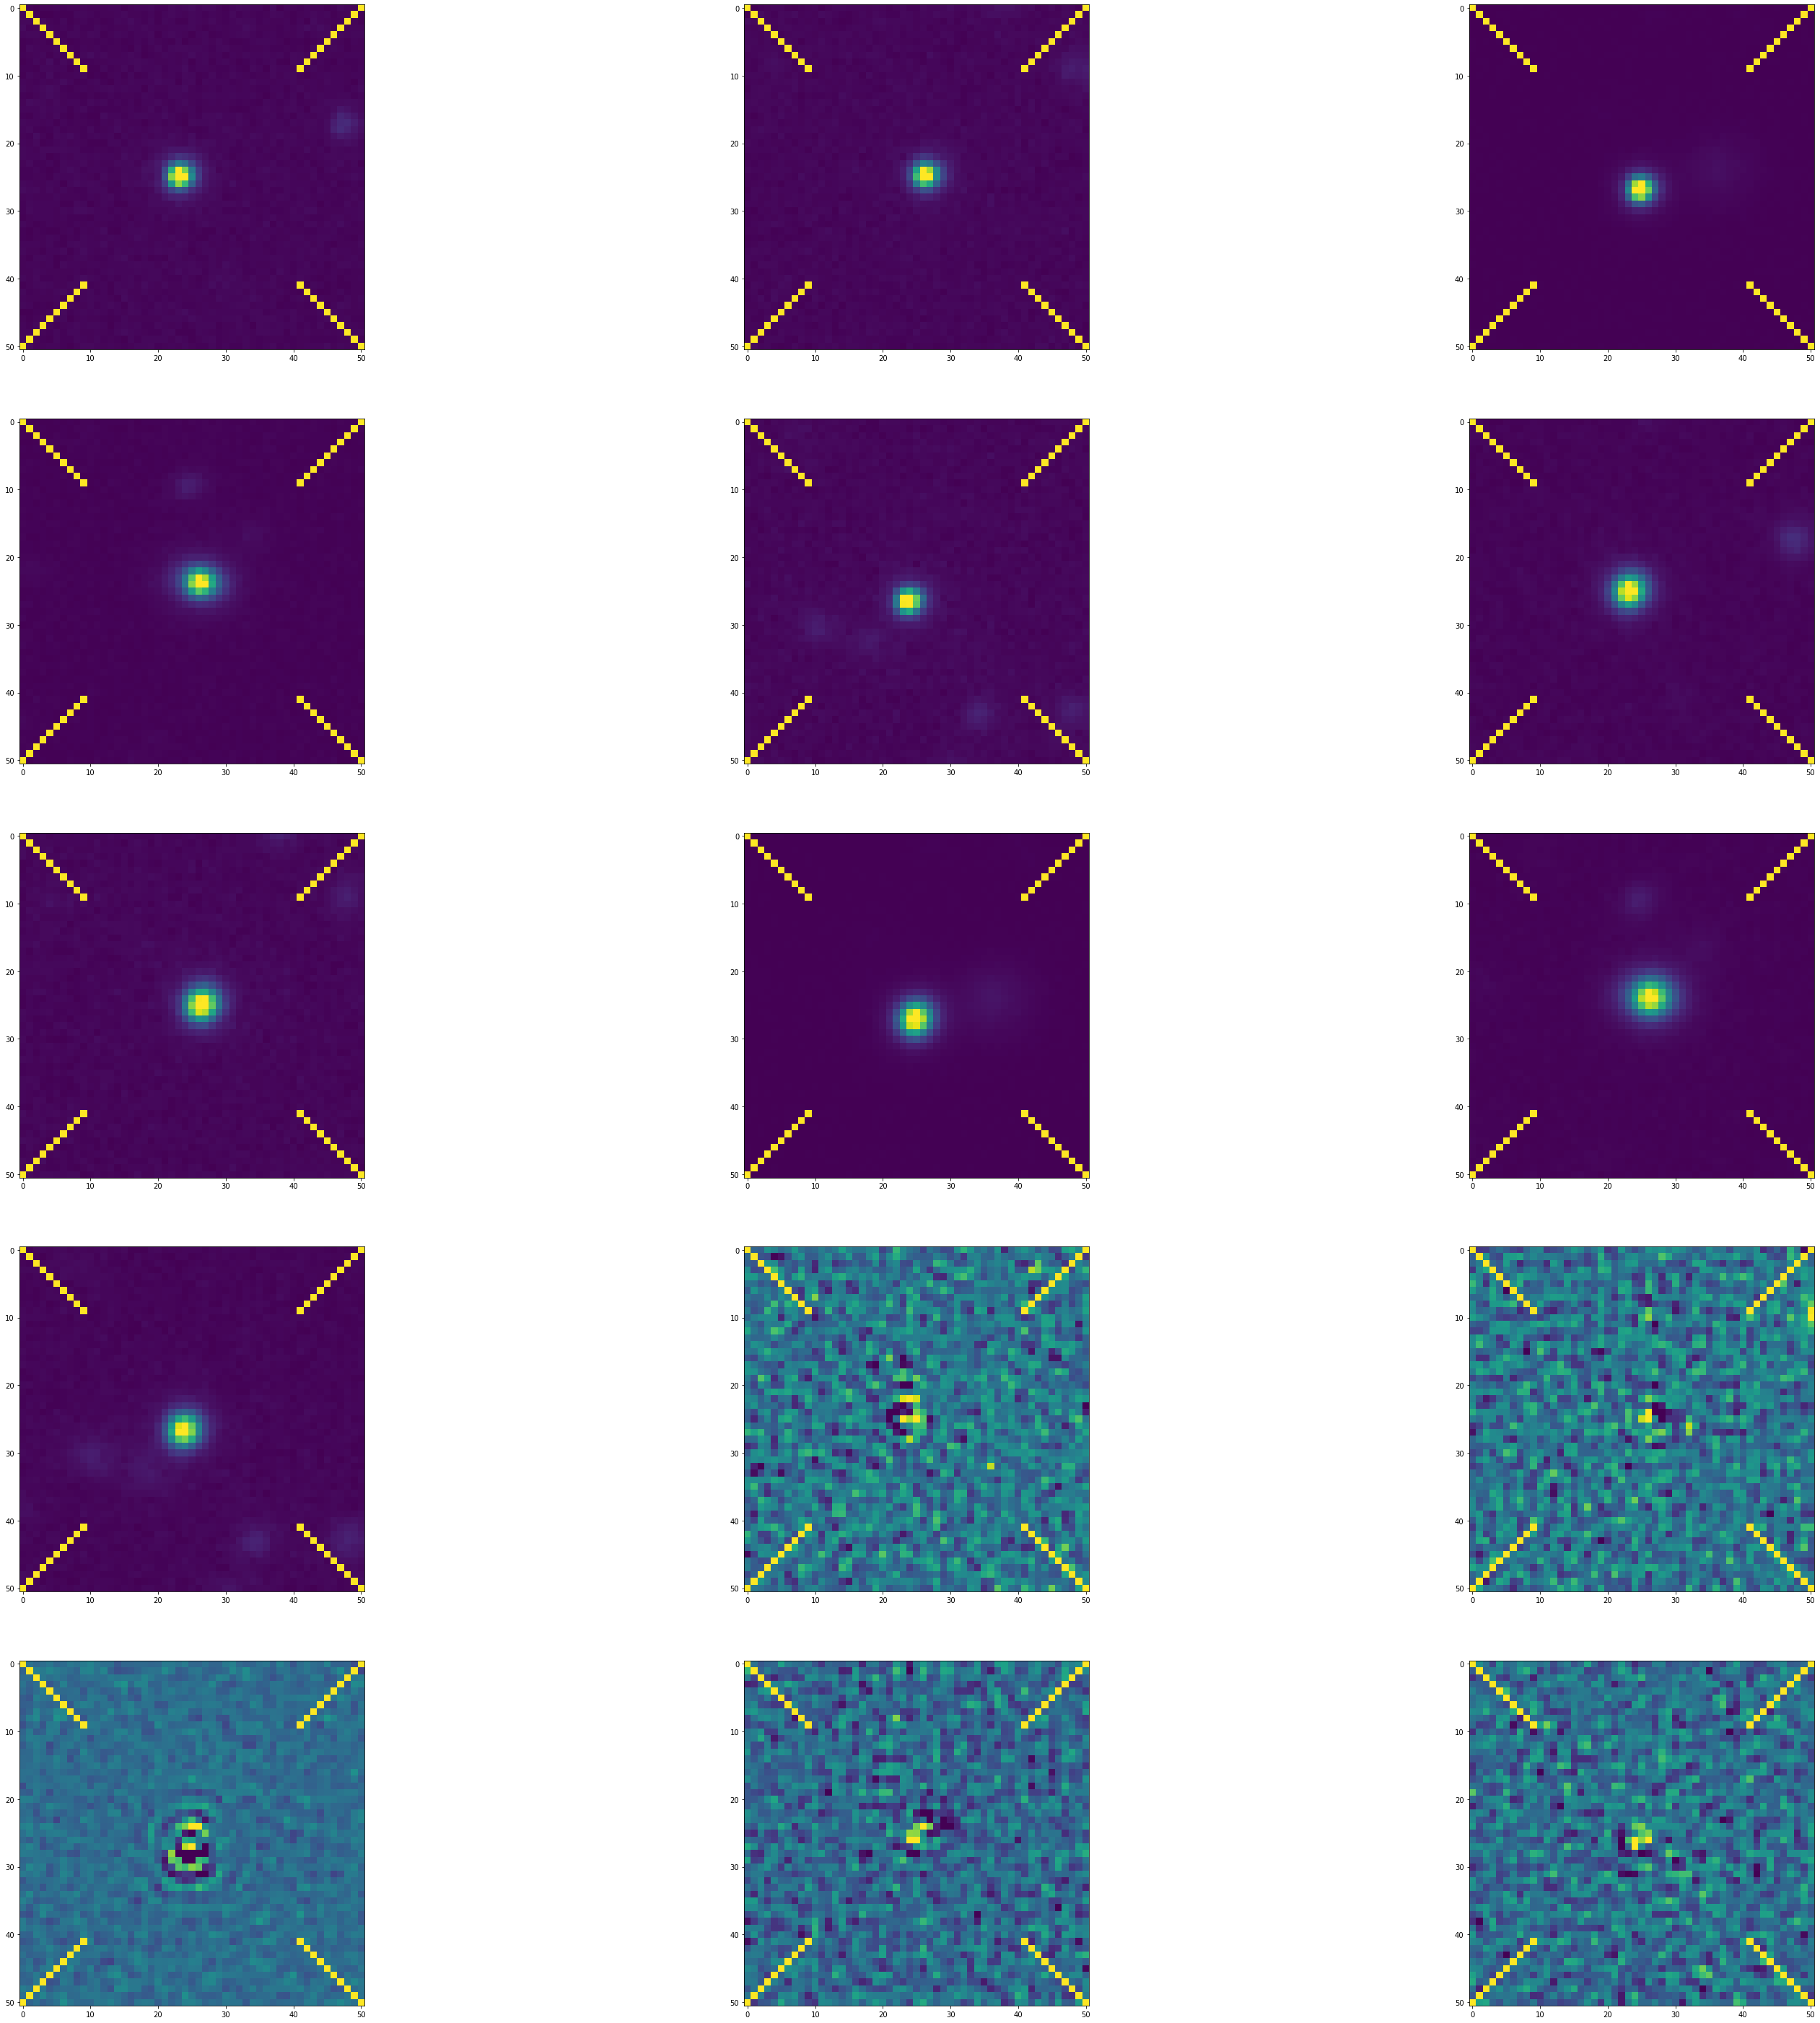

In [9]:
fig = plt.figure(figsize=(51, 51))
columns = 3
rows = 5

i = 1
for c in range(0, columns):
    for r in range(0, rows):
        fig.add_subplot(rows, columns, i)
        plt.imshow(supernovaImages[r][c])
        i += 1
plt.show()

## Data Splitting
---
We have to split the data into 3 different sets: training, validation, and testing. Utilizing the *split_space_data*
function we imported from *utils.py* this is pretty straightforward.

P.S. Sorry that each line is so long... We tried multiple ways of making this easier on the eyes but this makes
the most sense!

In [10]:
(X_train, X_train_normal, Y_train, file_path_train, observation_number_train), (X_test, X_test_normal, Y_test, file_path_test, observation_number_test) = split_space_data(
    all_images_normalized, 
    all_data["images"],
    all_data["targets"], 
    all_data["file_paths"], 
    all_data["observation_numbers"], 
    0.1
)

In [11]:
(X_train, X_train_normal, Y_train, file_path_train, observation_number_train), (X_valid, X_valid_normal, Y_valid, file_path_valid, observation_number_valid) = split_space_data(
    X_train,
    X_train_normal,
    Y_train,
    file_path_train,
    observation_number_train,
    0.2
)

## Model Definition
---
We define the model in a function just to keep things separated nicely. <strong>Feel free to change the model however
    you like! Try things out :D </strong>

In [12]:
def build_model(X, Y, params):
    
    # Figure out the data shape
    input_shape = (X.shape[1], X.shape[2], X.shape[3])
    
    # Define the model object to append layers to
    model = Sequential()
    
    # Add first layer
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_1"],
        kernel_size=(3,3),
        strides=(1,1),
        border_mode='same',
        data_format='channels_first',
        input_shape=input_shape
    ))
    model.add(Activation('relu'))
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_1"],
        kernel_size=(3,3),
        strides=(2,2),
        border_mode='same',
        data_format='channels_first',
        input_shape=input_shape
    ))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    # Second layer
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_2"],
        strides=(1,1),
        kernel_size=(3,3),
        border_mode='same',
        data_format='channels_first',
    ))
    model.add(Activation('relu'))
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_2"],
        strides=(2,2),
        kernel_size=(3,3),
        border_mode='same',
        data_format='channels_first',
    ))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    # Third layer
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_3"],
        strides=(1,1),
        kernel_size=(3,3),
        border_mode='same',
        data_format='channels_first',
    ))
    model.add(Activation('relu'))
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_3"],
        strides=(2,2),
        kernel_size=(3,3),
        border_mode='same',
        data_format='channels_first',
    ))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    # Fourth layer
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_4"],
        strides=(1,1),
        kernel_size=(3,3),
        border_mode='same',
        data_format='channels_first',
    ))
    model.add(Activation('relu'))
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_4"],
        strides=(2,2),
        kernel_size=(3,3),
        border_mode='same',
        data_format='channels_first',
    ))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    # Fifth layer
    model.add(Conv2D(
        filters=params["NUMBER_OF_FILTERS_4"],
        strides=(1,1),
        kernel_size=(3,3),
        border_mode='same',
        data_format='channels_first',
    ))
    model.add(Activation('relu'))
    
    # Output layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dropout(params["DROPOUT_PERCENT"]))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    return model

## Model Parameters
---
We have separated parameters into 2 buckets with the folowing definitions:
- user_params: Information *about* the model for record keeping
- model_params: Information *for* the model to consume

In [13]:
user_params = {
    "INITIALS": "cc",
    "MODEL_DESCRIPTION": "My first public model!",
    "VERSION": "1"
}

model_params = {
    "LEARNING_RATE": 0.00014148226882681195,
    "BATCH_SIZE": 368,
    "DROPOUT_PERCENT": 0.4488113054975806,
    "NUMBER_OF_FILTERS_1": 25,
    "NUMBER_OF_FILTERS_2": 63,
    "NUMBER_OF_FILTERS_3": 119,
    "NUMBER_OF_FILTERS_4": 210,    
    "NUMBER_OF_EPOCHS": 40,
}

## Model Experimentation
---


START MODEL SEARCH (model 0 of 1)


d:\github\supernova-classifier\virtual\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), data_format="channels_first", input_shape=(3, 51, 51..., padding="same")`
  app.launch_new_instance()
d:\github\supernova-classifier\virtual\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=25, kernel_size=(3, 3), strides=(2, 2), data_format="channels_first", input_shape=(3, 51, 51..., padding="same")`
d:\github\supernova-classifier\virtual\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=63, strides=(1, 1), kernel_size=(3, 3), data_format="channels_first", padding="same")`
d:\github\supernova-classifier\virtual\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=63, strides=(2, 2), kerne

{'LEARNING_RATE': 0.00014148226882681195, 'BATCH_SIZE': 368, 'DROPOUT_PERCENT': 0.4488113054975806, 'NUMBER_OF_FILTERS_1': 25, 'NUMBER_OF_FILTERS_2': 63, 'NUMBER_OF_FILTERS_3': 119, 'NUMBER_OF_FILTERS_4': 210, 'NUMBER_OF_EPOCHS': 40}
Train on 36000 samples, validate on 9000 samples
Epoch 1/40
35696/36000 [============================>.] - ETA: 2s - loss: 0.2841 - acc: 0.8841
Epoch 00001: val_loss improved from inf to 0.25513, saving model to model/mdl.hdf5
36000/36000 [==============================] - 401s 11ms/step - loss: 0.2829 - acc: 0.8847 - val_loss: 0.2551 - val_acc: 0.8966
Epoch 2/40
35696/36000 [============================>.] - ETA: 2s - loss: 0.1667 - acc: 0.9372
Epoch 00002: val_loss improved from 0.25513 to 0.17569, saving model to model/mdl.hdf5
36000/36000 [==============================] - 399s 11ms/step - loss: 0.1668 - acc: 0.9372 - val_loss: 0.1757 - val_acc: 0.9292
Epoch 3/40
35696/36000 [============================>.] - ETA: 2s - loss: 0.1140 - acc: 0.9571
Epoch 

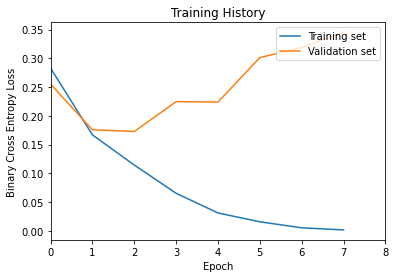

FINISHED MODEL SEARCH. 32722.671875 SECONDS.


<Figure size 432x288 with 0 Axes>

In [14]:
MODEL_AMOUNT = 1

for current_model_number in range(MODEL_AMOUNT):
    
    # Indicate and log model start
    print("START MODEL SEARCH (model {} of {})".format(current_model_number, MODEL_AMOUNT))
    start = process_time()
    
    # Randomize specific parameters if we are doing a search
    # Feel free to add or change the current parameters
    if MODEL_AMOUNT > 1:
        params["LEARNING_RATE"] = 10 ** np.random.uniform(-4, -2)
        params["BATCH_SIZE"] = 16 * np.random.randint(1, 96)
        params["DROPOUT_PERCENT"] = np.random.uniform(0.0, 0.6)
        params["NUMBER_OF_FILTERS_1"] = np.random.randint(4, 32)
        params["NUMBER_OF_FILTERS_2"] = np.random.randint(16, 64)
        params["NUMBER_OF_FILTERS_3"] = np.random.randint(32, 128)
        params["NUMBER_OF_FILTERS_4"] = np.random.randint(64, 256) 
        
    # Build the model and catch if the model acrhitectur is not valid
    try:
        model = build_model(X_train, Y_train, model_params)
    except Exception as e:
        print("That didn't work!")
        print(e)
        continue
        
    # Create the specific model name
    model_name = user_params["INITIALS"] + "_convolutional_" + str(user_params["VERSION"]) + str(current_model_number)
    user_params["VERSION"] = user_params["VERSION"] + str(1)
    
    # Define an optimizer for the model
    adam_optimizer = Adam(
        lr=model_params["LEARNING_RATE"], 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=None, 
        decay=0.0
    )
    
    # Compile the model
    model.compile(
        loss="binary_crossentropy", 
        optimizer=adam_optimizer,
        metrics=['accuracy']
    )
    
    # Figure out where to save the model checkpoints
    checkpoint_file = MODEL_PATH + "mdl.hdf5"
    checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=2, save_best_only=True)
    
    # Create an early stopping callback
    early_stopping_callback = EarlyStopping(patience=5, min_delta=0.0005, verbose=2)
    
    # Actually train the model
    print(model_params)
    history = model.fit(
        X_train,
        Y_train,
        batch_size=model_params["BATCH_SIZE"],
        nb_epoch=model_params["NUMBER_OF_EPOCHS"],
        verbose=1,
        validation_data=(X_valid, Y_valid),
        callbacks=[checkpointer, early_stopping_callback]
    )
    
    # Reload the best model
    model = load_model(checkpoint_file)
    
    # Get final predictions for the model and write to a file
    predictions = model.predict(X_test).flatten()
    model_metrics = get_metrics(predictions, Y_test)
    create_result_csv(user_params, model_params, model_metrics, file_name=RESULTS_PATH + MODEL_LOGGING_FILE)
    
    # Save the model to a unique location if the Pippin metric is better than the papers
    if model_metrics["PIPPIN_METRIC"] < 0.202:
        copyfile(checkpoint_file, checkpoint_filepath + "{}.hdf5".format(model_name))
        
    # Plot the model history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training History')
    plt.ylabel('Binary Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.xlim([0, len(history.history['loss'])])
    plt.legend(['Training set', 'Validation set'], loc='upper right')
    plt.show()
    
    # Reset plot to clean up extra lines
    plt.clf()
    
    # Get some indication of process length
    final = process_time()
    print('FINISHED MODEL SEARCH. {} SECONDS.'.format(str(final-start)))